## Pseudo-spectral algorithm for solving the non-dimensionalised version of the partial differential equations described in the paper "Evidence for a scale-dependent root-augmentation feedback and patchy invasion"

**Requirements** - the following implementation requires installation of CuPy (https://docs.cupy.dev/en/stable/install.html), a prerequisite of which is an NVIDIA CUDA GPU with compute capability greater than 3.0. 

The dimensional model equations are given by equation 7 (see paper). The first two equations describe the rate of change of above-ground biomass of two species on the Brazilian Island of Trindade. Our model is able to qualitatively describe the ongoing invasion process on Trindade Island; specifically, $\textit{Guilandina bonduc}$ is spreading and displacing $\textit{Cyperus atlanticus Hemsl.}$ in a patchy invasion process. This is due to water limitation, but see the paper for more details on the underlying ecological processes. 

The non-dimensionalised form of the equations solved in this notebook are:

\begin{align}
\frac{\partial b_i}{\partial t} &= g^i_b b_i (1-b_i) - \mu_i b_i + \delta_{b_i} \frac{w}{w+w_i^*}\phi_i * b_i,~~ i=1,2,  \\
\frac{\partial w}{\partial t} &= p - \nu \left(1 - \sum_{i=1}^{n} \rho_i b_i \right) w - w \sum_{i=1}^{n} g_w^i + \delta_w \Delta w,
\end{align}

where 

\begin{align}
g_{b}^i &= \nu \lambda_i \int_\Omega g_i(\mathbf{x},\mathbf{x}',t) w(\mathbf{x}',t) d\mathbf{x}', \\
g_{w}^i &= \gamma_i \int_\Omega g_i(\mathbf{x}',\mathbf{x},t) b(\mathbf{x}',t) d\mathbf{x}',
\end{align}

and

\begin{align}
g_{i} &= \frac{1}{2 \pi \sigma_{g_i}^2} \operatorname{exp}\left(-\frac{|\mathbf{X}-\mathbf{X}'|^2}{2 [\sigma_{g_i}(1+b_i(\mathbf{X},T)]^2)}\right), \\
\phi_{i} &= \frac{1}{2 \pi} \left[ \frac{\sigma_{d_i}}{\left(|\mathbf{x}-\mathbf{x}'|+\sigma_{d_i}^2 \right)^{3/2}} \right].
\end{align}

The variables $b_1(\mathbf{x},t)$ and $b_2(\mathbf{x},t)$ represent $\textit{Guilandina}$ and $\textit{Cyperus}$, respectively, and $w(\mathbf{x},t)$ represents the soil water concentration. The dimensional parameters in the paper can be related to the presented non-dimensional parameters via the following scalings:

| **Quantity** | **Scaling** | 
| --- | --- |
|$$b_{i}$$ | $$B_i/K_i$$ |
|$$w$$ | $$\Lambda_1 W/N $$ |
|$$h$$ | $$\Lambda_1 H/N$$ |
|$$\nu$$ | $$N/M_1$$ |
|$$\lambda_i$$ | $$\Lambda_i/\Lambda_1$$ |
|$$\mu_i$$ | $$M_i/M_1$$ |
|$$\alpha$$ | $$A/M_1$$ |
|$$q$$ | $$Q/K_1$$ |
|$$\mathbf{x}$$ | $$\mathbf{X}/S_{G_1}$$ |
|$$t$$ | $$M_1 T$$ |
|$$p$$ | $$\Lambda_1 P /(NM_1)$$ |
|$$\gamma_i$$ | $$\Gamma_i K_i /M_1$$ |
|$$\eta_i$$ | $$E_i K_i$$ |
|$$\rho_i$$ | $$R_i$$ |
|$$\sigma_{g_i}$$ | $$S_{G_i}/S_{G_1}$$ |
|$$\sigma_{\delta_i}$$ | $$S_{D_i}/S_{G_1}$$ | 
|$$\delta_{b_i}$$ | $$\Theta_i/M_i$$ |
|$$\delta_w$$ | $$D_W/(M_1S_{G_1}^2)$$ |
|$$w_i^*$$ | $$\Lambda_1 W_i^* /N$$ | 

First, we import some modules, define the parameters that capture patchy invasion dynamics, and calculate the non-dimensional quantities described in the above table. Parameters can be adjusted here according to Fig. 7, or otherwise. 

In [1]:
import numpy as np
import seaborn as sns
import cupy as cp
from cupy.fft import fft2,ifft2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
from gbgw import initsigmac, gfunc
from tqdm import tqdm

P=1450 # precipitation
E1=16; E2=5 # root-shoot ratio
K1=0.7; K2=0.35 # carrying capacity
M1=7.05; M2=7.05 # death rate
N=15; # evaporation rate
Lam1=0.06; Lam2=0.16 # growth rates
Gam1=15; Gam2=5 # water uptake rates
Rh1=0.1; Rh2=0.1 # evaporation reduction due to shading
SG1=0.5; # minimum lateral extent of roots
SD1=0.5; SD2=0.01; # dispersal distance
Theta1=3.25; Theta2=3.25; # dispersal rates
Ws1=0.5; Ws2=2 # half-saturation constant of dispersal rates
DW=0.5; # soil water diffusion rate 

# non-dimensional parameters
p=Lam1*P/(N*M1);
nu=N/M1; lam1=1; lam2=Lam2/Lam1; mu1=1; mu2=M2/M1;
gam1=Gam1*K1/M1; gam2=Gam2*K2/M1
eta1=E1*K1; eta2=E2*K2; rho1=Rh1; rho2=Rh2
sg1=1; sd1=SD1/SG1; sd2=SD2/SG1;
ws1=Lam1*Ws1/N; ws2=Lam1*Ws2/N
db1=Theta1/M1; db2=Theta2/M1;
dw=DW/(M1*SG1**2)

Set up the 2d spatial domain. 

In [2]:
Xmax=300 # domain size. Set to 300 if loading ic-fig7.npz initial data
xmax=Xmax/SG1 # scaled domain
Lx=xmax/2 # x-component of spectral domain length
Ly=xmax/2 # y-component spectral domain
dt=0.02 # timestep
NN=128*20; # number of points in spatial discretisation. Must be even. Set to 2**11 if loading ic-fig7.npz initial data
Tmax=10 # maximum time of solution (dimensional)
tmax=Tmax*M1 # maximum time of solution (non-dimensional)
steps=int(tmax/dt) # number of timesteps             

# define spatial domain
dx=(2*Lx/NN) # grid size
x=(2*Lx/NN)*np.arange(-NN/2,NN/2,1); y=x; Ymax=Xmax
extent=[0,Xmax,0,Ymax] # for plotting
X=x*SG1; Y=X
[xx,yy]=np.asarray(np.meshgrid(x,y))

# define spectral domain and load onto GPU
kx = (np.pi/Lx)*np.concatenate((np.arange(0,NN/2 +1),np.arange(-NN/2 +1,0)))
ky = (np.pi/Ly)*np.concatenate((np.arange(0,NN/2 +1),np.arange(-NN/2 +1,0)))
[kxx, kyy] = np.meshgrid(kx, ky)
ksq = kxx**2 + kyy**2
ksq = cp.asarray(ksq).astype('float32')
kxx = cp.asarray(kxx).astype('float32')

Define initial conditions. The function "kinetics" defines the spatially independent model, which can be solved quickly to obtain uniform steady states. To replicate invasion dynamics on Trindade Island, we wish to calculate the uniform steady state $(b_1, b_2, w) = (0, b_2^*, w^*)$, i.e. the $\textit{Cyperus}-only$ steady state, and then add small patches of $\textit{Guilandina}$ at the centre of the domain. We define these patches using a Gaussian distribution with "gaussian2d".

We have performed the above steps and saved initial conditions in 'ic-fig7.npz', which are loaded in the below cell. These initial conditions are identical those used in Fig. 7. However, the user can use the functions below to define their own invasion initial conditions, i.e. $\verb|u1 = b1p2 + gauss2d(xx, yy, x0, y0, sig0)|$, etc. 

In [28]:
# Load initial condition from file.
u1, u2, v1  = np.load('ic-fig7.npz')['arr_0'] # b1, b2, w

# Calculate steady state and add Gaussian perturbations

def kinetics(y,t): # define spatially indepentent model
    u1,u2,v1=y
    du1dt=-mu1*u1+nu*u1*v1*(1-u1)*(1+eta1*u1)**2+db1*v1/(v1+ws1)*u1
    du2dt=-mu2*u2+nu*lam2*u2*v1*(1-u2)*(1+eta2*u2)**2+db2*v1/(v1+ws2)*u2
    dv1dt=p-nu*v1*(1-rho1*u1-rho2*u2)-v1*gam2*u2*(1+eta2*u2)**2 
    - v1*gam1*u1*(1+eta1*u1)**2
    dydt=[du1dt,du2dt,dv1dt]
    return dydt
tstop=500
tode=np.arange(0,tstop,0.0001)
b1p2, b2p2, wp2 = odeint(kinetics, [0,1,0.05], tode)[-1] # pure b2 state (b1=0)

def gauss2d(xx,yy,x0,y0,sig0): # x0, y0 defines the centre of the perturbation, and sig0 its width
    g=np.exp(-((xx-x0)**2+(yy-y0)**2)/(2*sig0**2))
    return g

# Add own initial condition here instead if needed. Example commented.

# 𝚞𝟷 = 𝚋𝟷𝚙𝟸 + 0.5*𝚐𝚊𝚞𝚜𝚜𝟸𝚍(𝚡𝚡, 𝚢𝚢, 𝚡𝟶, 𝚢𝟶, 𝚜𝚒𝚐𝟶)
# u2 = b2p2
# v1 = wp2

#  Add a small noise term (not really needed since Gaussian perturbations already give spatial variation)
u1 = u1 + np.random.uniform(0,0.005,(NN,NN))
u2 = u2 + np.random.uniform(0,0.005,(NN,NN))
v1 = v1 + np.random.uniform(0,0.005,(NN,NN))

# Load variables and their FFTs onto GPU. Note 'float32' is very important here in order to speed up the computation
u1 = cp.array(u1).astype('float32')
u2 = cp.array(u2).astype('float32')
v1 = cp.array(v1).astype('float32')

u1hat = fft2(u1)
u2hat = fft2(u2)
v1hat = fft2(v1)

# Save the initial condition if needed
#np.savez_compressed('data/0.0',
                    #[u1.get(),v1.get(),u2.get(),p,0]) # save initial condition

Define the model using the cupy.fuse() decorator which fuses functions into a single kernel. cupy.fuse() cannot fuse FFTs so any terms containing them must be precomputed before being passed to the below functions. $\verb|D1|, \verb|D2|, \verb|gb1|, \verb|gb2|$ are placeholders for the convolution terms $\phi_i * b_i$, and integral terms $g_b^i$, $g_w^i$. 

In [29]:
# Define equations as cuda kernels

@cp.fuse()
def ku1in(u1, v1, u2, p, gb1, D1):
    ku1in = -mu1*u1 + nu*gb1*u1*(1-u1) + db1*D1*v1/(v1+ws1)
    return ku1in

@cp.fuse()
def ku2in(u1, v1, u2, p, D2):
    ku2in = -mu2*u2+nu*lam2*u2*v1*(1-u2)*(1+eta2*u2)**2 + db2*D2*v1/(v1+ws2)
    return ku2in

@cp.fuse()
def kv1in(u1,v1,u2,p,gw1):
    kv1in=p - nu*v1*(1-rho1*u1-rho2*u2) - v1*gam2*u2*(1+eta2*u2)**2-gam1*gw1*v1 
    return kv1in

The below cell computes the terms $g_b^i$ and $g_w^i$ using the method of Gilad et al (https://dl.acm.org/doi/10.1016/j.jcp.2005.12.003). It involves their approximation as a linear combination of convolutions. The helper function 'gbgw.py' is invoked for this.

In [30]:
# Approximate integral terms
Nl=5 # number of convolutions for integral approximation
smin1=1; smax1=(1+eta1);
phi1c=(1+eta1*u1);
philc=initsigmac(smin1,smax1,Nl)
Hfc=cp.zeros((Nl,NN,NN)).astype('float32')
for l in range(0,Nl):
    Hfc[l,:,:]=philc[l]**2*cp.exp(-philc[l]**2*ksq/2)/sg1**2
gb1, gw1 = gfunc(u1, v1, Hfc, phi1c, philc, NN, NN, Nl)

Create a plotting window for monitoring the solution.

In [31]:
%matplotlib qt
maximum1=K1; maximum2=K2; minimum=0
fig1 = plt.gcf()
fig1.show()
fig1.canvas.draw()
ax1 = fig1.add_subplot(111)
im1 = ax1.imshow(u1.get(),
                 extent=extent,
                 cmap=plt.cm.Greys,
                 origin='lower',
                 interpolation='nearest',
                 alpha=1)
im2 = ax1.imshow(u2.get(),
                 extent=extent,
                 cmap=plt.cm.Greys,
                 origin='lower',
                 interpolation='nearest',
                 alpha=0.4)
divider = make_axes_locatable(ax1)
divider = make_axes_locatable(ax1)
fig1.suptitle('T='+str(int(0/M1))+' [yr]'+', P='+str(int(np.round(p*N*M1/Lam1)))+' [mm]')

store_every = 1 # save every store_every years
plot_every = 0.1 # plot every plot_every years

Runge-Kutta fourth order scheme. The limiting factor for GPU calculations is often memory, therefore we delete stored quantities regularly.

In [32]:
for n in tqdm(range(0,steps)):
    phi1c=(1+eta1*u1);
    gb1, gw1=gfunc(u1, v1, Hfc, phi1c, philc, NN, NN, Nl) 
    D1=cp.real(ifft2(cp.exp(-cp.abs(cp.sqrt(ksq))*sd1)*u1hat))
    ku11=dt*fft2(ku1in(u1,v1,u2,p,gb1,D1))
    del D1, gb1
    D2=cp.real(ifft2(cp.exp(-cp.abs(cp.sqrt(ksq))*sd2)*u2hat))
    ku21 =dt*fft2(ku2in(u1, v1, u2, p, D2))
    del D2
    kv11 =dt*fft2(kv1in(u1, v1, u2, p, gw1))
    del u1, v1, u2, gw1
    Eu1=1 # no diffusion term in u1 equation so set to 1
    u12=cp.real(ifft2(Eu1*(u1hat+ku11/2)))
    u1=Eu1**2*u1hat+(Eu1**2*ku11)/6
    del Eu1, ku11
    Ev1=cp.exp(-dw*ksq*dt/2)
    v12=cp.real(ifft2(Ev1*(v1hat+kv11/2)))
    v1=Ev1**2*v1hat+(Ev1**2*kv11)/6
    del Ev1, kv11
    Eu2=1 # no diffusion term in u2 equation so set to 1
    u22=cp.real(ifft2(Eu2*(u2hat+ku21/2)))
    u2=Eu2**2*u2hat+(Eu2**2*ku21)/6
    del Eu2, ku21
       
    phi1c=(1+eta1*u12);
    gb1, gw1=gfunc(u12,v12,Hfc,phi1c,philc,NN,NN,Nl) 
    D1=cp.real(ifft2(cp.exp(-cp.abs(cp.sqrt(ksq))*sd1)*fft2(u12)))
    ku12=dt*fft2(ku1in(u12, v12, u22, p, gb1, D1))
    del D1, gb1
    D2=cp.real(ifft2(cp.exp(-cp.abs(cp.sqrt(ksq))*sd2)*fft2(u22)))
    ku22=dt*fft2(ku2in(u12, v12, u22, p, D2))
    del D2
    kv12=dt*fft2(kv1in(u12, v12, u22, p, gw1))
    del u12, v12, u22, gw1
    Eu1=1
    u13=cp.real(ifft2(Eu1*u1hat+ku12/2))
    u1=u1+(2*Eu1*ku12)/6
    del Eu1, ku12    
    Ev1=cp.exp(-(dw*ksq-0*1j*kxx)*dt/2)
    v13=cp.real(ifft2(Ev1*v1hat+kv12/2))
    v1=v1+(2*Ev1*kv12)/6
    del Ev1, kv12
    Eu2=1
    u23=cp.real(ifft2(Eu2*u2hat+ku22/2))
    u2=u2+(2*Eu2*ku22)/6
    del Eu2, ku22
       
    phi1c=(1+eta1*u13);
    gb1, gw1=gfunc(u13, v13, Hfc, phi1c, philc, NN, NN, Nl) 
    D1=cp.real(ifft2(cp.exp(-cp.abs(cp.sqrt(ksq))*sd1)*fft2(u13)))
    ku13=dt*fft2(ku1in(u13, v13, u23, p, gb1, D1))
    del D1, gb1
    D2=cp.real(ifft2(cp.exp(-cp.abs(cp.sqrt(ksq))*sd2)*fft2(u23)))
    ku23=dt*fft2(ku2in(u13, v13, u23, p, D2))
    del D2
    kv13=dt*fft2(kv1in(u13, v13, u23, p, gw1))
    del u13, v13, u23, gw1
    Eu1=1
    u14=cp.real(ifft2(Eu1**2*u1hat+Eu1*ku13))
    u1=u1+(2*Eu1*ku13)/6
    del Eu1, ku13
    Ev1=cp.exp(-(dw*ksq-0*1j*kxx)*dt/2)
    v14=cp.real(ifft2(Ev1**2*v1hat+Ev1*kv13))
    v1=v1+(2*Ev1*kv13)/6
    del Ev1, kv13
    Eu2=1
    u24=cp.real(ifft2(Eu2**2*u2hat+Eu2*ku23))
    u2=u2+(2*Eu2*ku23)/6
    del Eu2, ku23
       
    phi1c=(1+eta1*u14);
    gb1, gw1=gfunc(u14, v14, Hfc, phi1c, philc, NN, NN, Nl) 
    D1=cp.real(ifft2(cp.exp(-cp.abs(cp.sqrt(ksq))*sd1)*fft2(u14)))
    ku14 =dt*fft2(ku1in(u14, v14, u24, p, gb1, D1))
    u1=cp.real(ifft2(u1+ku14/6))
    del D1, gb1
    D2=cp.real(ifft2(cp.exp(-cp.abs(cp.sqrt(ksq))*sd2)*fft2(u24)))
    ku24 =dt*fft2(ku2in(u14, v14, u24, p, D2))
    u2=cp.real(ifft2(u2+ku24/6))
    del D2, ku24
    kv14 =dt*fft2(kv1in(u14, v14, u24, p, gw1))
    v1=cp.real(ifft2(v1+kv14/6))
    del kv14, gw1
    u1hat=fft2(u1) # not sure why but this seems to stabilise the method
    v1hat=fft2(v1) # perhaps something to do with numpys fft2
    u2hat=fft2(u2) # not needed in the equivalent 1D numerical scheme...
    t=(n+1)*dt

    if (int(n+1)  % int(np.round(M1*store_every/dt))) == 0: # save data
        np.savez_compressed('data/'+str(np.round(t,1)), [u1.get(), v1.get(), u2.get(), p, t])
    if (n % int(np.round(M1*0.1/dt))) == 0: # plot current timestep
        im1.set_array(u1.get())
        im2.set_array(u2.get())
        fig1.suptitle('T='+str(int(t/M1))+' [yr]'+',  P='+str(int(np.round(p*N*M1/Lam1)))+' [mm]')
        fig1.canvas.draw()
        plt.pause(0.01) 

100%|███████████████████████████████████████| 3525/3525 [31:16<00:00,  1.88it/s]


Plot snapshot of $B_1 + B_2$.

In [23]:
u1_plot, u2_plot, v_plot, p, t = np.load('data/70.4.npz', allow_pickle=True)['arr_0']

mycmap1=sns.diverging_palette(25, 105, n = 100,as_cmap=True) # b1 diverging colourmap
mycmap2=sns.light_palette("yellow",n_colors=100,as_cmap=True) # b2 sequential colourmap

# create mask for plotting, to be applied to b2
mid_alpha = 0.05
u2alpha = u2_plot / np.max(u2_plot) + (mid_alpha - 1) * u1_plot / np.max(u1_plot) * u2_plot / np.max(u2_plot) 

/tmp/ipykernel_59751/2232918275.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


Text(0.5, 0.98, 'T=9 [yr], P=1450 [mm]')

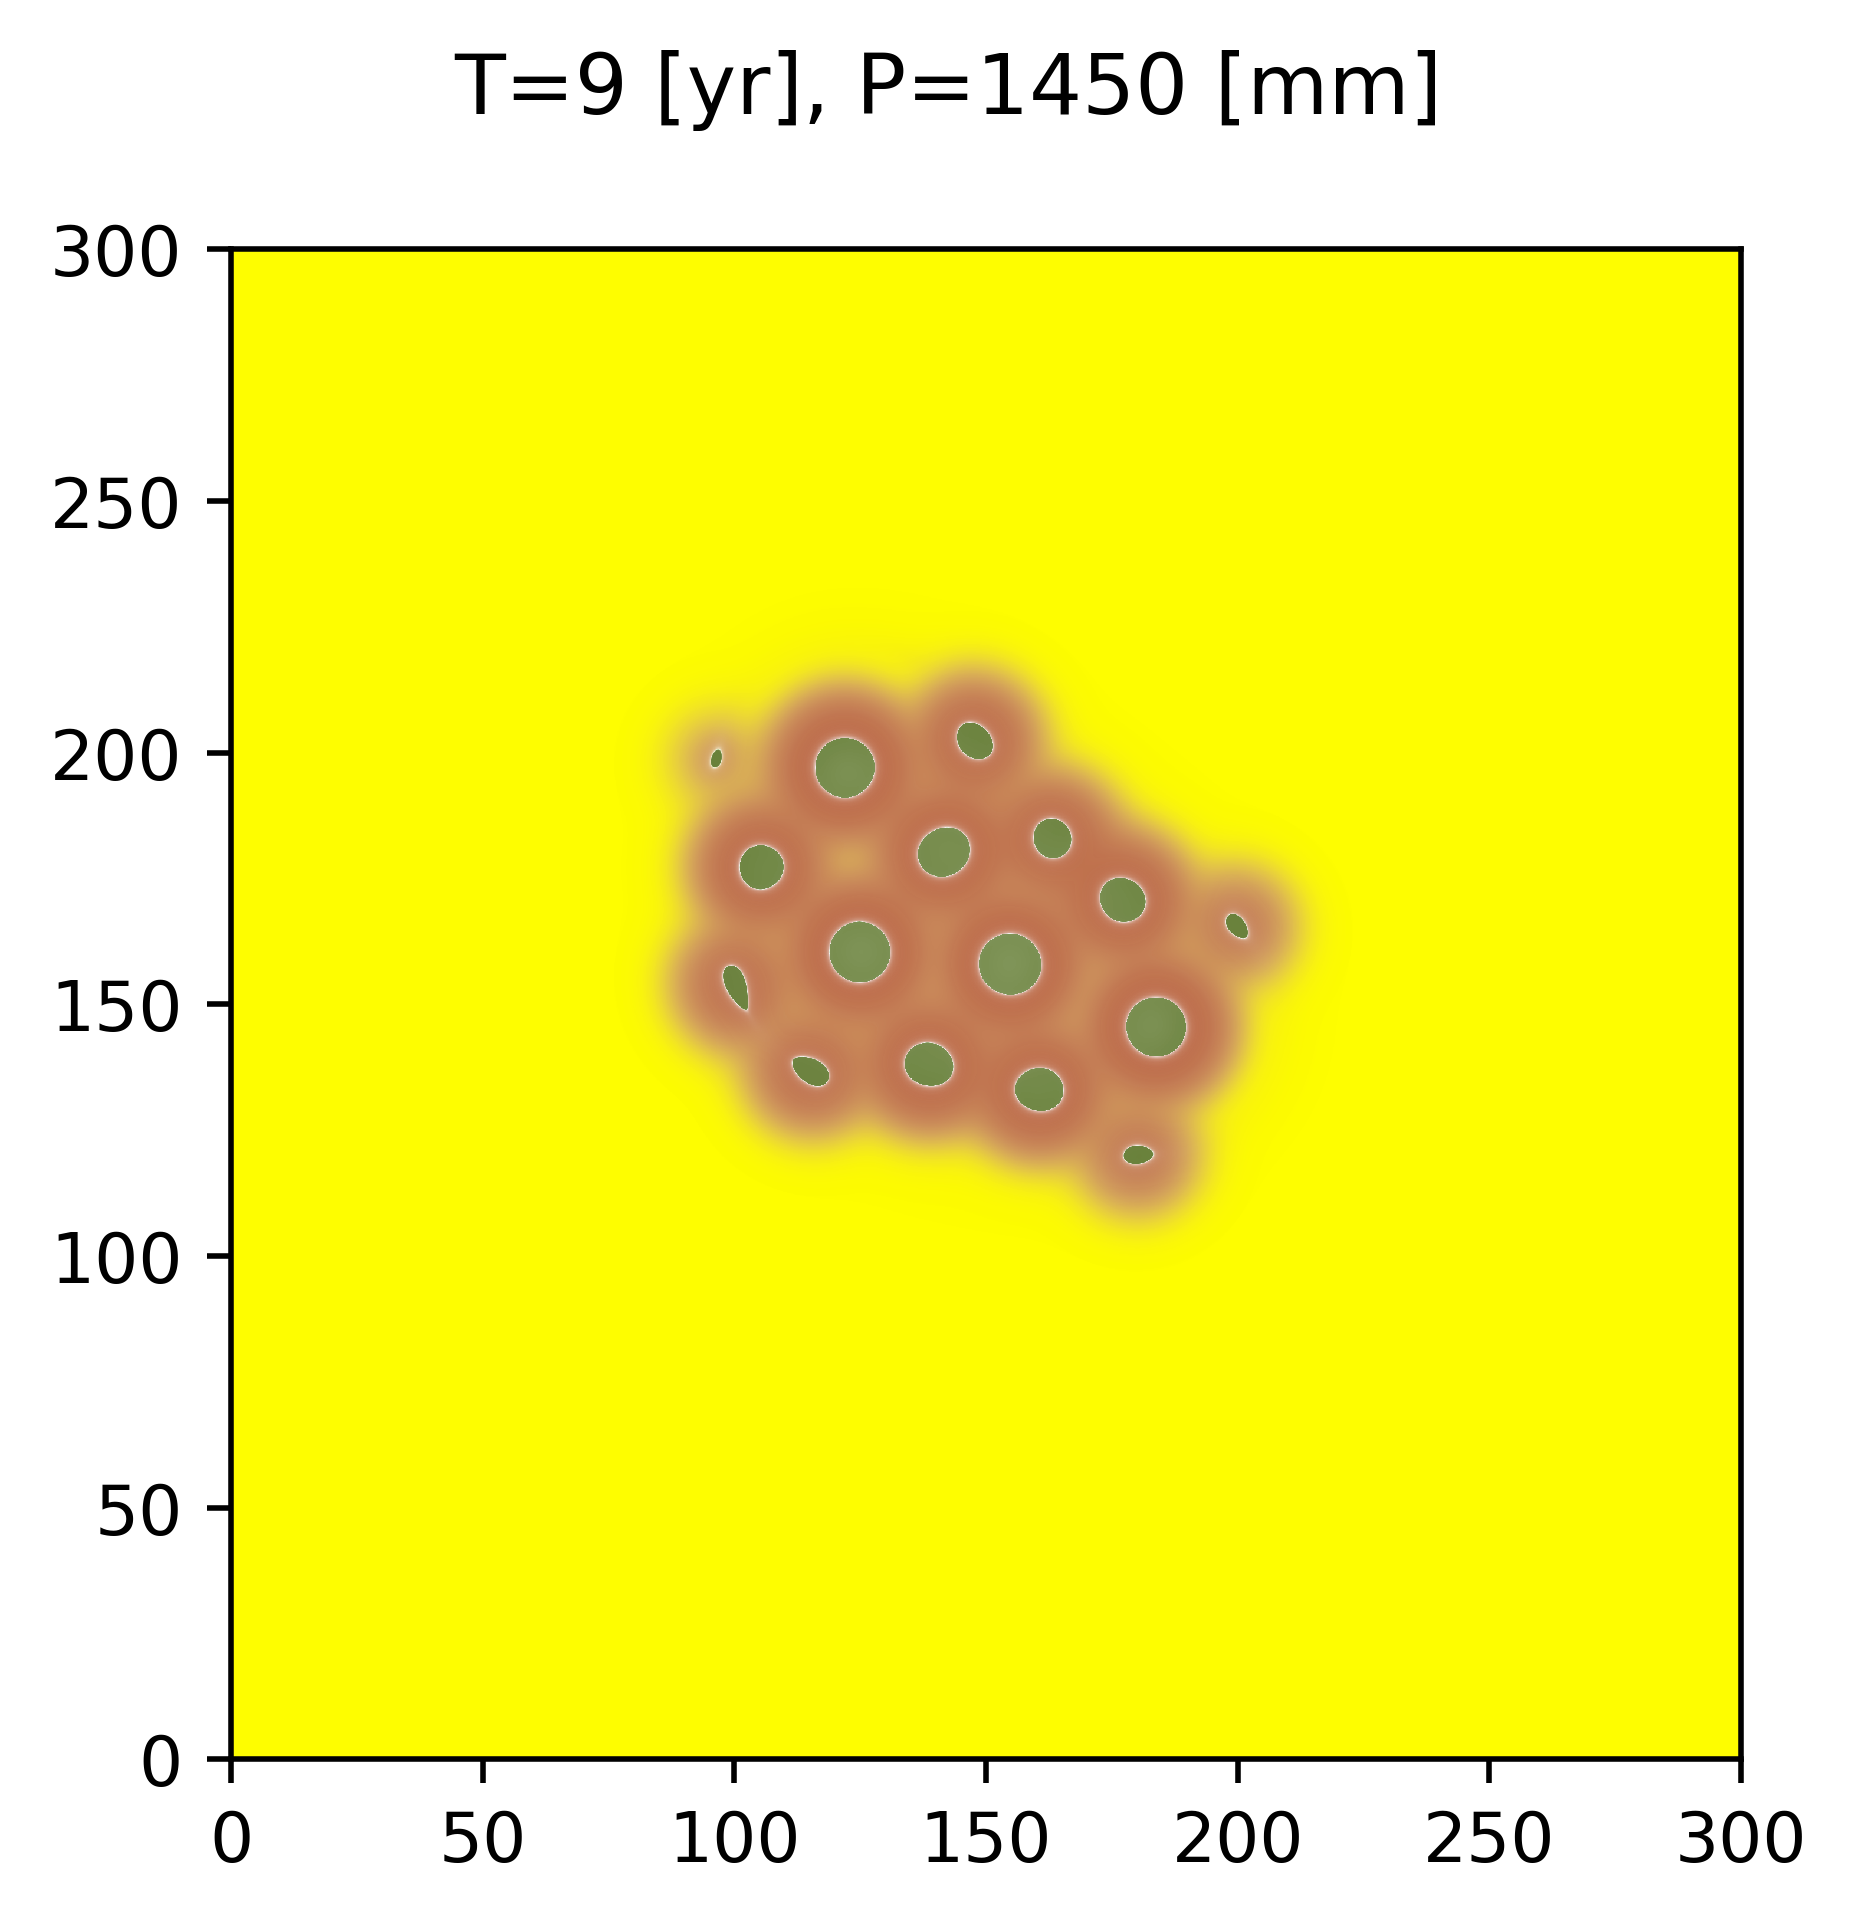

In [27]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 500 # change dpi of the plot

maximum1=K1; maximum2=K2; minimum=0
fig2 = plt.gcf()
fig2.show()
fig2.canvas.draw()
ax2 = fig2.add_subplot(111)
im1 = ax2.imshow(u1_plot,
                 extent=extent,
                 cmap=mycmap1,#plt.cm.Greys,
                 origin='lower',
                 interpolation='nearest',
                 alpha=1)
im2 = ax2.imshow(u2_plot,
                 extent=extent,
                 cmap=mycmap2,#plt.cm.Greys,
                 origin='lower',
                 interpolation='nearest',
                 alpha=u2alpha)
divider = make_axes_locatable(ax2)
divider = make_axes_locatable(ax2)
fig2.suptitle('T='+str(int(t/M1))+' [yr]'+', P='+str(int(np.round(p*N*M1/Lam1)))+' [mm]')